In [4]:
# dashboard.ipynb - Visualisation Orbital Insights

# ----------------------------
# 1️⃣ Installer les packages (si nécessaire)
# ----------------------------
!pip install psycopg2-binary sqlalchemy pandas plotly



     ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
      --------------------------------------- 0.0/2.1 MB 660.6 kB/s eta 0:00:04
      --------------------------------------- 0.1/2.1 MB 525.1 kB/s eta 0:00:04
     - -------------------------------------- 0.1/2.1 MB 651.6 kB/s eta 0:00:04
     ---- ----------------------------------- 0.2/2.1 MB 1.3 MB/s eta 0:00:02
     ------ --------------------------------- 0.3/2.1 MB 1.5 MB/s eta 0:00:02
     -------- ------------------------------- 0.5/2.1 MB 1.7 MB/s eta 0:00:01
     ---------- ----------------------------- 0.6/2.1 MB 1.8 MB/s eta 0:00:01
     ------------- -------------------------- 0.7/2.1 MB 1.8 MB/s eta 0:00:01
     -------------- ------------------------- 0.8/2.1 MB 1.9 MB/s eta 0:00:01
     --------------- ------------------------ 0.8/2.1 MB 2.0 MB/s eta 0:00:01
     --------------- ------------------------ 0.8/2.1 MB 2.0 MB/s eta 0:00:01
     --------------------- ------------------ 1.1/2.1 MB 2.0 MB/s


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
# dashboard.py (ou cellule d’un notebook)

import pandas as pd
from sqlalchemy import create_engine
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- ⚙️ Configuration de la connexion ---
DB_USER = "postgres"
DB_PASS = "postgres"
DB_HOST = "localhost"
DB_PORT = "5433"
DB_NAME = "space_dw"



In [7]:
# On crée un engine SQLAlchemy — plus fiable pour pandas
engine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)



In [20]:
# --- Chargement des données ---

with engine.connect() as conn:
    # Total launch mass par année
    df_mass_year = pd.read_sql("""
        SELECT d.year, SUM(s.launch_mass) AS total_mass
        FROM fact_launch f
        JOIN dim_date d ON f.date_key = d.date_key
        JOIN dim_satellite s ON f.satellite_key = s.satellite_key
        GROUP BY d.year
        ORDER BY d.year
    """, conn)

    # Contributions par pays (country_of_operator)
    df_country = pd.read_sql("""
        SELECT s.country_of_operator AS country, COUNT(f.fact_key) AS total
        FROM fact_launch f
        JOIN dim_satellite s ON f.satellite_key = s.satellite_key
        GROUP BY s.country_of_operator
    """, conn)

    # Launches par type d'utilisateur (operator type approximé)
    df_user_type = pd.read_sql("""
        SELECT s.operator AS user_type, COUNT(f.fact_key) AS total
        FROM fact_launch f
        JOIN dim_satellite s ON f.satellite_key = s.satellite_key
        GROUP BY s.operator
    """, conn)

    # Top countries par satellite contractor
    df_contractor_country = pd.read_sql("""
        SELECT s.country_of_contractor AS country, COUNT(f.fact_key) AS satellite_count
        FROM fact_launch f
        JOIN dim_satellite s ON f.satellite_key = s.satellite_key
        GROUP BY s.country_of_contractor
        ORDER BY satellite_count DESC
        LIMIT 10
    """, conn)

    # Top launch providers par nombre de lancements
    df_provider = pd.read_sql("""
        SELECT r.company AS provider, COUNT(f.fact_key) AS total_launches
        FROM fact_launch f
        JOIN dim_rocket r ON f.rocket_key = r.rocket_key
        GROUP BY r.company
        ORDER BY total_launches DESC
        LIMIT 10
    """, conn)



In [21]:
# --- Création d'une figure avec subplots ---
fig = make_subplots(
    rows=3, cols=2,
    specs=[[{"type": "scatter"}, {"type": "pie"}],
           [{"type": "pie"}, {"type": "bar"}],
           [{"type": "scatter"}, None]],
    subplot_titles=(
        "Total Launch Mass by Year",
        "Country contributions to satellite launches",
        "Launches per Satellite User Type",
        "Top contributing countries by satellite contractor",
        "Top Launch Providers by Number of Launches"
    )
)


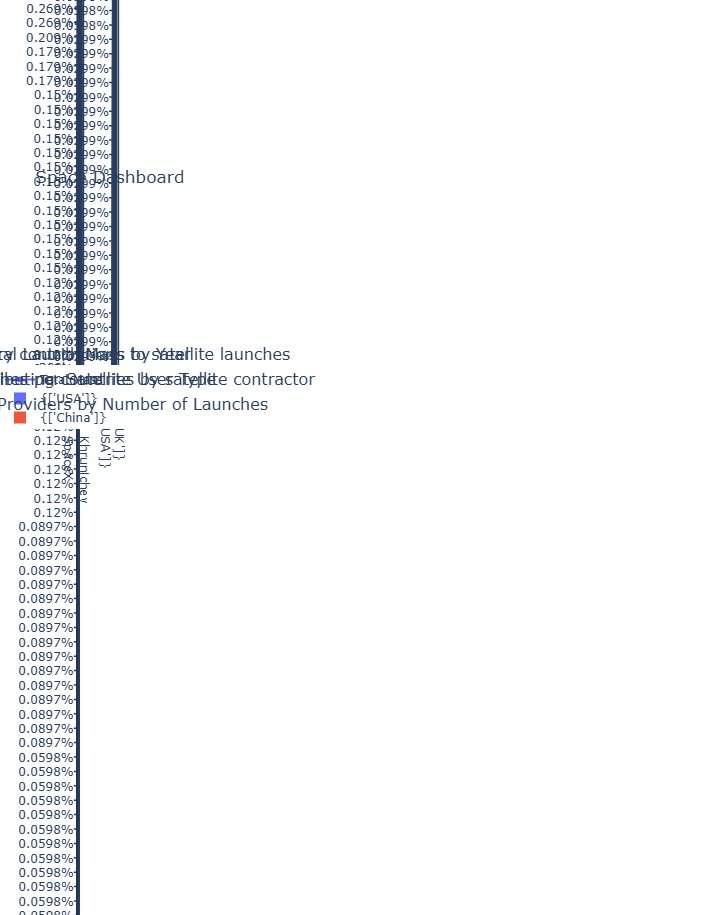

In [22]:
# --- Graphiques ---
# 1. Line chart - Total Launch Mass
fig.add_trace(go.Scatter(x=df_mass_year['year'], y=df_mass_year['total_mass'],
                         mode='lines+markers', name='Total Mass'),
              row=1, col=1)

# 2. Pie chart - Country contributions
fig.add_trace(go.Pie(labels=df_country['country'], values=df_country['total'],
                     name='Country Contributions'),
              row=1, col=2)

# 3. Pie chart - Launches per user type
fig.add_trace(go.Pie(labels=df_user_type['user_type'], values=df_user_type['total'],
                     name='User Type'),
              row=2, col=1)

# 4. Bar chart - Top contractor countries
fig.add_trace(go.Bar(x=df_contractor_country['country'], y=df_contractor_country['satellite_count'],
                     name='Top Contractor Countries'),
              row=2, col=2)

# 5. Bubble chart - Top launch providers
fig.add_trace(go.Scatter(x=df_provider['provider'], y=df_provider['total_launches'],
                         mode='markers', marker=dict(size=df_provider['total_launches']/50, color='gold'),
                         name='Launch Providers'),
              row=3, col=1)

# --- Mise en page globale ---
fig.update_layout(height=900, width=1200, title_text="Space Dashboard", showlegend=True)
fig.show()